In [1]:
import scvelo as scv
import scanpy as sc
import pandas as pd 
import numpy as np 
import os 
from pathlib import Path

In [2]:
notebook_dir = os.getcwd()
notebook_dir

'/Users/omercagatay/Desktop/Thesis/git_repo/SALMON/notebooks/scvelo'

In [5]:
Path(notebook_dir).parents[3]

PosixPath('/Users/omercagatay/Desktop/Thesis')

In [7]:
abs_path = str(Path(notebook_dir).parents[3])
os.chdir(abs_path)
os.getcwd()

'/Users/omercagatay/Desktop/Thesis'

# Adata

In [8]:
adata = sc.read_10x_h5('data/Xenium_V1_mouse_pup_outs/cell_feature_matrix.h5') 

In [9]:
adata.var = adata.var.rename(columns={"gene_ids":"Ensemble ID"})
adata.var.reset_index(inplace=True, drop = False, names= "gene_name")
adata.obs.reset_index(inplace=True, drop=False, names= "cell_id")

# Cell Summary 

In [10]:
df_cells = pd.read_csv("data/Xenium_V1_mouse_pup_outs/cells.csv.gz")

In [11]:
df_adata_obs = df_cells[['cell_id','x_centroid',"y_centroid", "transcript_counts", "total_counts", "cell_area", "nucleus_area"]]

In [12]:
adata.obs = df_adata_obs.copy()

In [13]:
del df_adata_obs
del df_cells

# Transcripts

In [14]:
transcripts = pd.read_csv("data/Xenium_V1_mouse_pup_outs/transcripts_filtered_gut.csv")

- remove transcripts which are not assigned to a cell

In [15]:
transcripts["cell_mapped"] = transcripts["cell_id"].apply(lambda x: "unassigned" if x == "UNASSIGNED" else "assigned")

In [16]:
# check proportion of transcripts assigned to a cell 
print(transcripts["cell_mapped"].value_counts())
print((transcripts["cell_mapped"].value_counts()[1]/len(transcripts))*100, "%")


cell_mapped
assigned      2318958
unassigned      18598
Name: count, dtype: int64
0.795617302858199 %


In [17]:
tr = transcripts[transcripts["cell_id"] != "UNASSIGNED" ]
tr.reset_index(inplace=True, drop=True)
tr = tr.drop(columns=["Unnamed: 0"])

In [18]:
tr[tr["feature_name"]=="Fam25c"]

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,cell_mapped
65205,282183646369707,cjakafmb-1,0,Fam25c,4860.7190,4718.6830,20.856134,6.439905,G9,3.899890,assigned
365309,282183646373029,hbjagkal-1,0,Fam25c,5118.5933,4653.6310,24.444098,7.356981,G9,5.739840,assigned
700338,282132107013630,hbdlpnkc-1,0,Fam25c,5448.3320,4453.0310,25.934357,15.365672,G10,1.153433,assigned
768410,282183647079631,hbjnfcbf-1,0,Fam25c,5279.7200,4490.7515,24.493109,7.909501,G9,2.771367,assigned
1542825,282132107018385,hbaodlik-1,0,Fam25c,5648.7837,5009.4546,21.973145,15.902228,G10,0.811230,assigned
1560618,282132107543324,haocheoo-1,0,Fam25c,5735.1390,5051.5880,24.093110,7.944462,G10,0.612669,assigned


In [14]:
# divide data in nuclei and cytopasm
tn = tr[tr['overlaps_nucleus'] == 1]
tc = tr[tr['overlaps_nucleus'] == 0]

# create the cellxgene matrix for nuc counts and cytoplasmic
nuc = pd.crosstab(tn['cell_id'],tn['feature_name'])
cyt = pd.crosstab(tc['cell_id'],tc['feature_name'])

In [27]:
cell_tr = pd.crosstab(tr['cell_id'],tr['feature_name'])
adata = adata[adata.obs['cell_id'].isin(cell_tr.index)]

View of AnnData object with n_obs × n_vars = 9790 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'

In [28]:
adata.write("data/Xenium_V1_mouse_pup_outs/adata_gut.h5ad")

In [6]:
adata = scv.read("data/Xenium_V1_mouse_pup_outs/adata_gut.h5ad")

In [7]:
adata

AnnData object with n_obs × n_vars = 9790 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'

In [9]:
sc.pp.filter_genes(adata,min_cells=2)

In [12]:
adata

AnnData object with n_obs × n_vars = 9790 × 377
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome', 'n_cells'

In [11]:
adata[:,adata.var['gene_name']=="Fam25c"]

View of AnnData object with n_obs × n_vars = 9790 × 0
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome', 'n_cells'

In [19]:
adata = adata[:,adata.var['gene_name']!="Fam25c"]

In [20]:
# eliminate genes 
adata = adata[:,adata.var['gene_name'].isin(nuc.columns)]
adata = adata[:,adata.var['gene_name'].isin(cyt.columns)]

#get the cells which has a transcripts mappep to it 
adata = adata[adata.obs['cell_id'].isin(nuc.index)]
adata = adata[adata.obs['cell_id'].isin(cyt.index)]

# create "spliced", "unspliced" layers since scvelo looks for them
nucsort = nuc.loc[adata.obs['cell_id'],adata.var["gene_name"]]
cytsort = cyt.loc[adata.obs['cell_id'],adata.var["gene_name"]]

adata.layers['spliced'] = np.array(cytsort)
adata.layers['unspliced'] = np.array(nucsort)

In [21]:
adata

AnnData object with n_obs × n_vars = 9681 × 377
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome', 'n_cells'
    layers: 'spliced', 'unspliced'

In [39]:
adata.write("data/Xenium_V1_mouse_pup_outs/adata_gut_tr.h5ad")

# Velocity 

- 3 options for calculating velocity:
    - Deterministic 
    - Dynamic
    - Stochastic 

Information can be found [here](https://scvelo.readthedocs.io/en/stable/about.html).

## Deterministic Velocity

In [18]:
adata = scv.read("data/Xenium_V1_mouse_pup_outs/adata_gut_tr.h5ad")
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [19]:
adata

AnnData object with n_obs × n_vars = 9681 × 378
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'
    obsm: 'spatial'
    layers: 'spliced', 'unspliced'

In [20]:
# filter, normalize 
sc.pp.filter_cells(adata,min_counts = 20)
sc.pp.filter_genes(adata,min_cells = 4)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [21]:
# pca, neighbours, umap, leiden
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors = 15 , n_pcs=0)
sc.tl.umap(adata,min_dist=0.05)
sc.tl.leiden(adata,resolution = 0.5 )

In [10]:
adata.obs.leiden.value_counts()

leiden
0    2452
1    2238
2    1861
3    1705
4    1140
5     124
6      49
Name: count, dtype: int64

- Calculate Moments

In [11]:
adata

AnnData object with n_obs × n_vars = 9569 × 374
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'leiden'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [12]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


- Calculate Velocity

In [13]:
scv.tl.velocity(adata, mode='deterministic')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [14]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:6

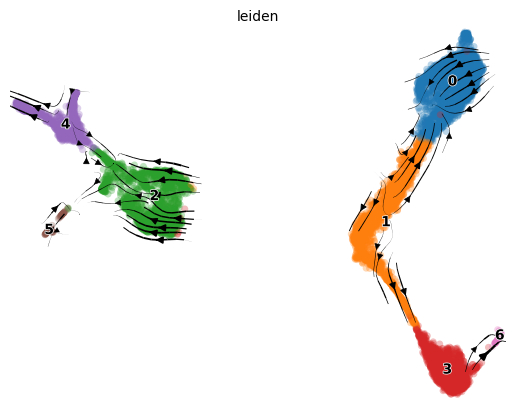

In [18]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden')

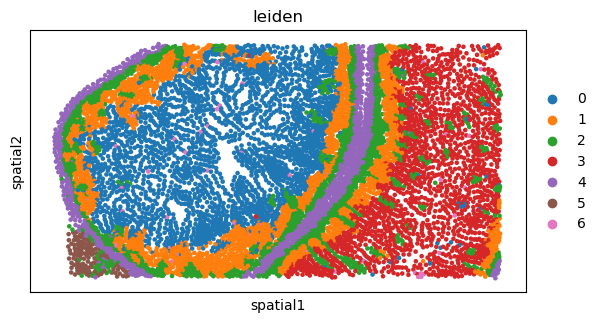

In [17]:
sc.pl.spatial(adata, color="leiden", spot_size = 15)

In [28]:
transition_matrix = scv.utils.get_transition_matrix(adata)

In [29]:
transition_matrix

<3696x3696 sparse matrix of type '<class 'numpy.float32'>'
	with 681987 stored elements in Compressed Sparse Row format>

## Dynamic Velocity 

In [22]:
adata = scv.read("data/Xenium_V1_mouse_pup_outs/adata_gut_tr.h5ad")
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [23]:
# filter, normalize 
sc.pp.filter_cells(adata,min_counts = 20)
sc.pp.filter_genes(adata,min_cells = 4)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [24]:

# pca, neighbours, umap, leiden
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=15,n_pcs=0)
sc.tl.umap(adata,min_dist=0.05)
sc.tl.leiden(adata, resolution=0.5)

In [25]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [26]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:02:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [27]:
scv.tl.velocity(adata, mode='dynamical')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [28]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [29]:
adata.obs.leiden.value_counts()

leiden
0    2452
1    2238
2    1861
3    1705
4    1140
5     124
6      49
Name: count, dtype: int64

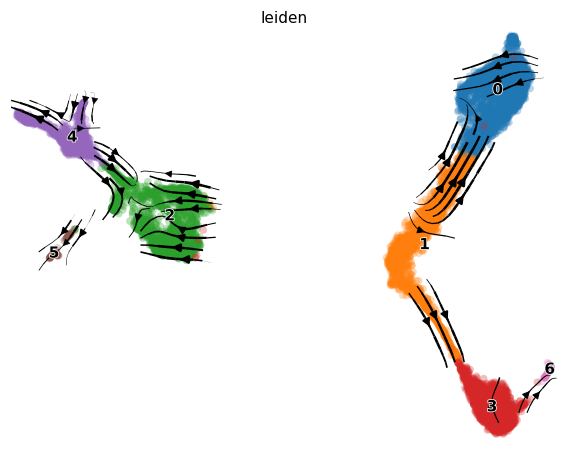

In [43]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.velocity_embedding_stream(adata, basis='umap',color="leiden", dpi=110)
    # scv.pl.velocity_embedding_stream(adata, basis='spatial',color="leiden")

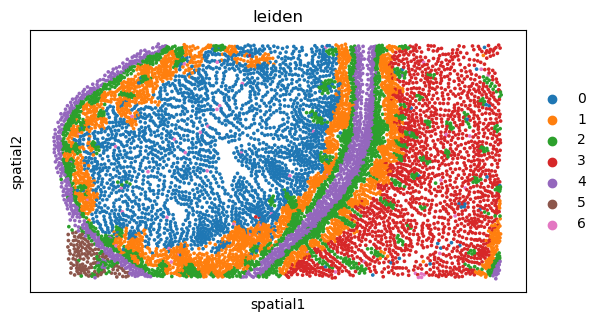

In [34]:
sc.pl.spatial(adata, color="leiden", spot_size = 12)

In [35]:
adata

AnnData object with n_obs × n_vars = 9569 × 374
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

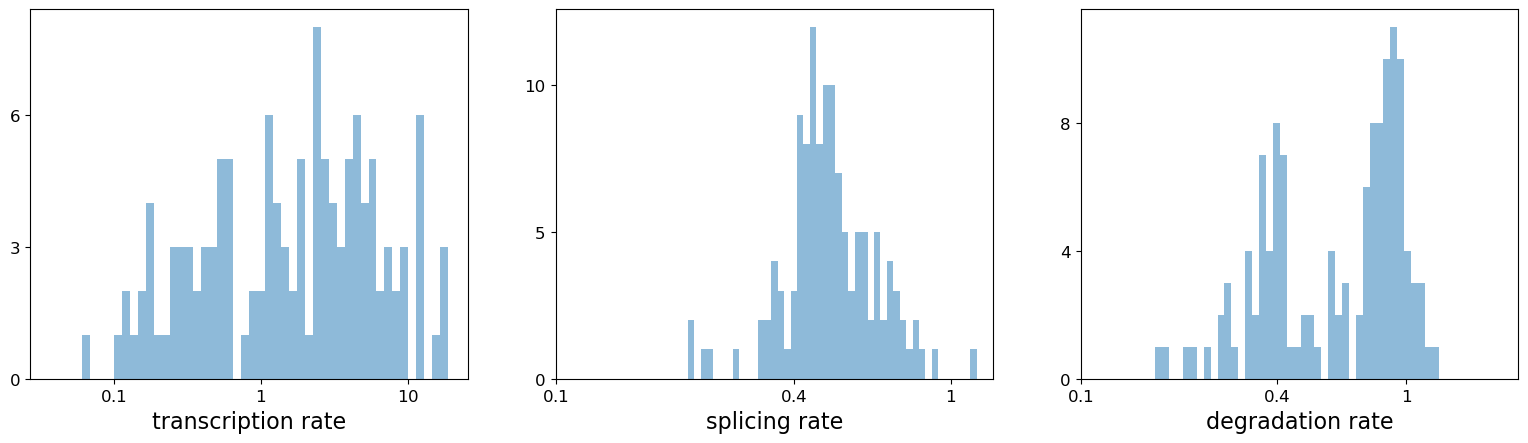

/var/folders/n1/3rys77050fl0ptsh50jc4t_40000gn/T/ipykernel_1652/3074921153.py:9: DeprecationWarning: `get_df` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please `AnnData::get_df` or Scanpy's `scanpy.get.obs_df` or `scanpy.get.var_df`.
  scv.get_df(adata, 'fit*', dropna=True).head()


,fit_r2,fit_alpha,fit_beta,fit_gamma,fit_t_,fit_scaling,fit_std_u,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling
2,0.619933,0.546798,1.522130,0.625981,3.843892,0.268412,0.107489,0.186216,2.445005e-01,0.0,0.0,0.347507,0.303894,0.483618,0.815471,1.046362
3,0.579508,0.499826,0.606630,0.440862,5.530427,0.900662,0.205798,0.193270,9.163533e-12,0.0,0.0,0.481301,0.712707,0.737987,1.869471,1.511240
4,0.680274,0.573378,0.961751,0.467210,6.114822,0.736802,0.161633,0.281526,1.456418e-01,0.0,0.0,0.479338,0.475621,0.780537,0.876799,1.811032
5,0.420349,0.257072,0.236089,0.359716,5.706502,2.909045,0.341416,0.117364,9.489126e-02,0.0,0.0,0.414510,0.985273,0.400270,1.367230,1.456045
6,0.595622,0.322573,0.571391,0.405949,5.140571,1.235056,0.195962,0.163955,1.284752e-01,0.0,0.0,0.379312,0.501361,0.484589,1.037628,1.464268


In [36]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]
kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

### latent time 

computing terminal states
    identified 5 regions of root cells and 4 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


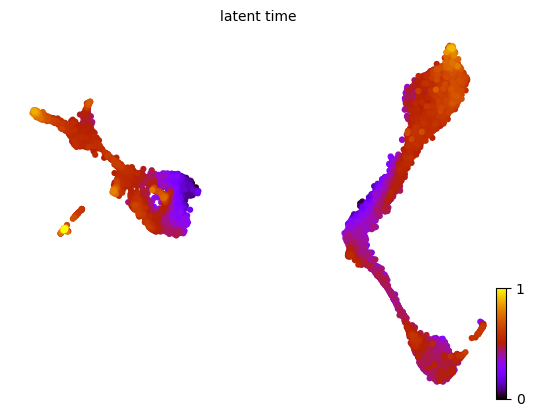

In [44]:
scv.tl.latent_time(adata)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

In [45]:
adata.var.set_index("gene_name",drop=True,inplace=True)

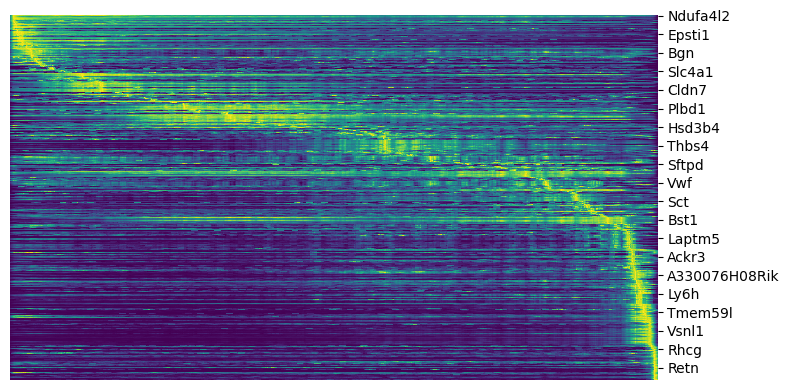

In [46]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time',  n_convolve=100)

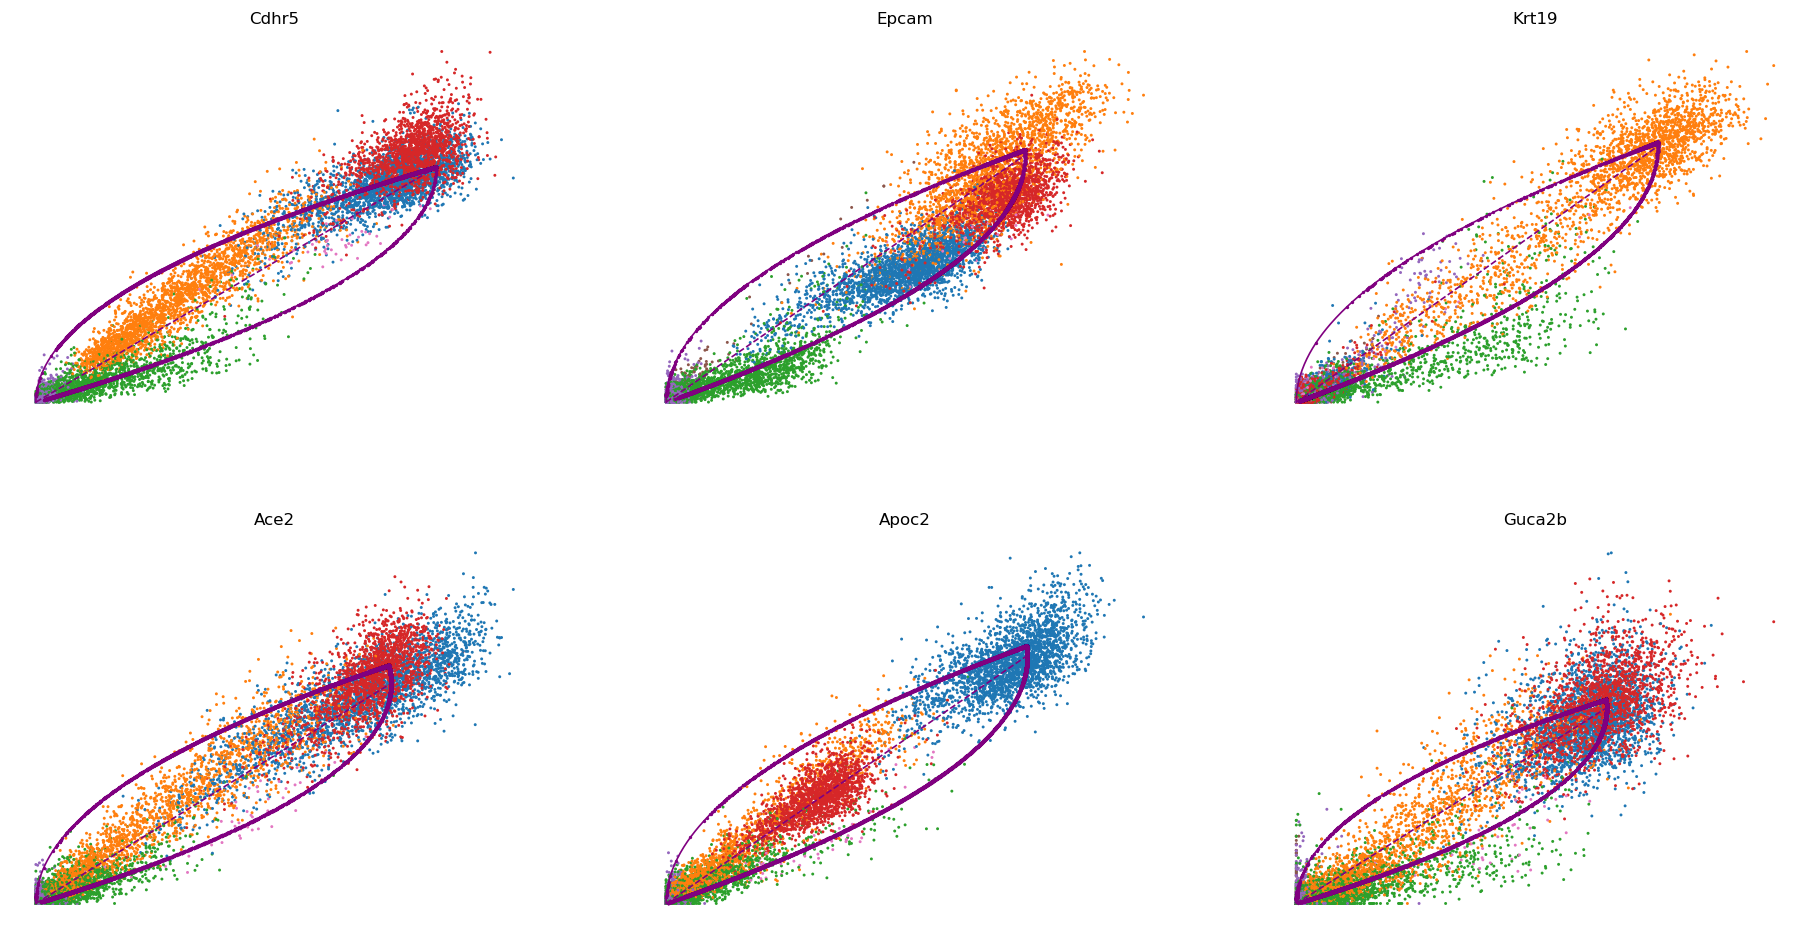

In [123]:
import warnings

top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.scatter(adata,color="leiden", basis=top_genes[:6], ncols=3, frameon=False,dpi=120)

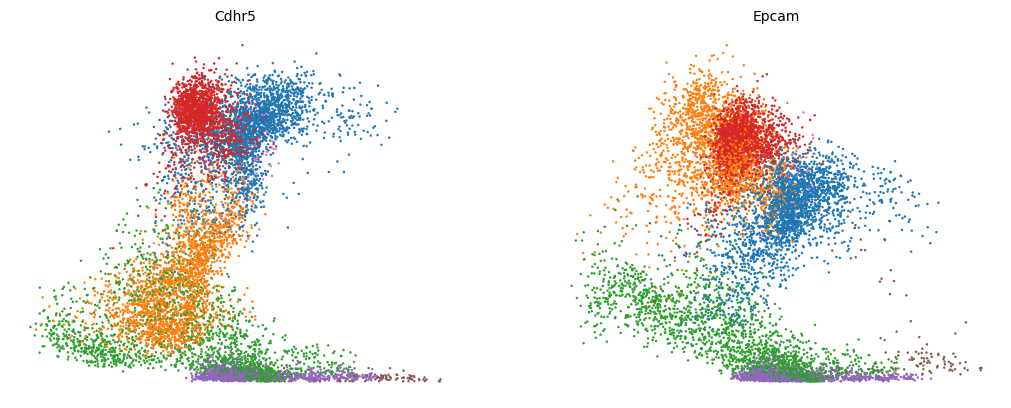

In [47]:
var_names = ['Cdhr5', 'Epcam']
#scv.pl.scatter(adata, var_names, frameon=False)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.scatter(adata, x='latent_time', y=var_names,color="leiden", frameon=False)


In [125]:
scv.tl.rank_dynamical_genes(adata, groupby='leiden')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:00) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


/var/folders/n1/3rys77050fl0ptsh50jc4t_40000gn/T/ipykernel_1652/3630236659.py:2: DeprecationWarning: `get_df` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please `AnnData::get_df` or Scanpy's `scanpy.get.obs_df` or `scanpy.get.var_df`.
  df = scv.get_df(adata, 'rank_dynamical_genes/names')
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/core/_anndata.py:257: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(data.obs[key])


,0,1,2,3,4,5,6
0,Cdhr5,Cdhr5,Rbp2,Epcam,Cnn1,Try10,Ace2
1,Epcam,Krt19,Hmgcs2,Ace2,Tagln,Prss3,Epcam
2,Apoc2,Krt8,Ndrg1,Cdhr5,Myh11,Dpt,Guca2b
3,Prap1,Prap1,Eng,Rbp2,Myl9,Ptprn2,Apoc2
4,Guca2b,Ace2,Tie1,Guca2b,Mylk,Tmem147,Rbp2


### Identify important genes 

In [55]:
scv.tl.rank_velocity_genes(adata, groupby='leiden', min_corr=.3)

df = scv.get_df(adata.uns['rank_velocity_genes']['names'])
df.head(6)

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/var/folders/n1/3rys77050fl0ptsh50jc4t_40000gn/T/ipykernel_1652/63878870.py:3: DeprecationWarning: `get_df` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please `AnnData::get_df` or Scanpy's `scanpy.get.obs_df` or `scanpy.get.var_df`.
  df = scv.get_df(adata.uns['rank_velocity_genes']['names'])


,0,1,2,3,4,5,6
0,Cndp2,Cdhr5,Cd36,Fmo5,Fxyd1,Krt8,Celf3
1,Cubn,Cldn2,Podxl,Hmgcs2,Epcam,Epcam,Anxa2
2,Lrp2,Slc34a2,Htra3,Pck1,Krt8,Ptprn2,Mylk3
3,Stmn1,Aqp1,Isca1,Cldn7,Plbd1,Rbp1,Cldn7
4,Abcb11,Sdc1,Rbp1,Prap1,Tspan8,Sdc1,Gatm
5,Gatm,Epsti1,Calcrl,Aldh1b1,Rbp2,Selenbp1,Scg3


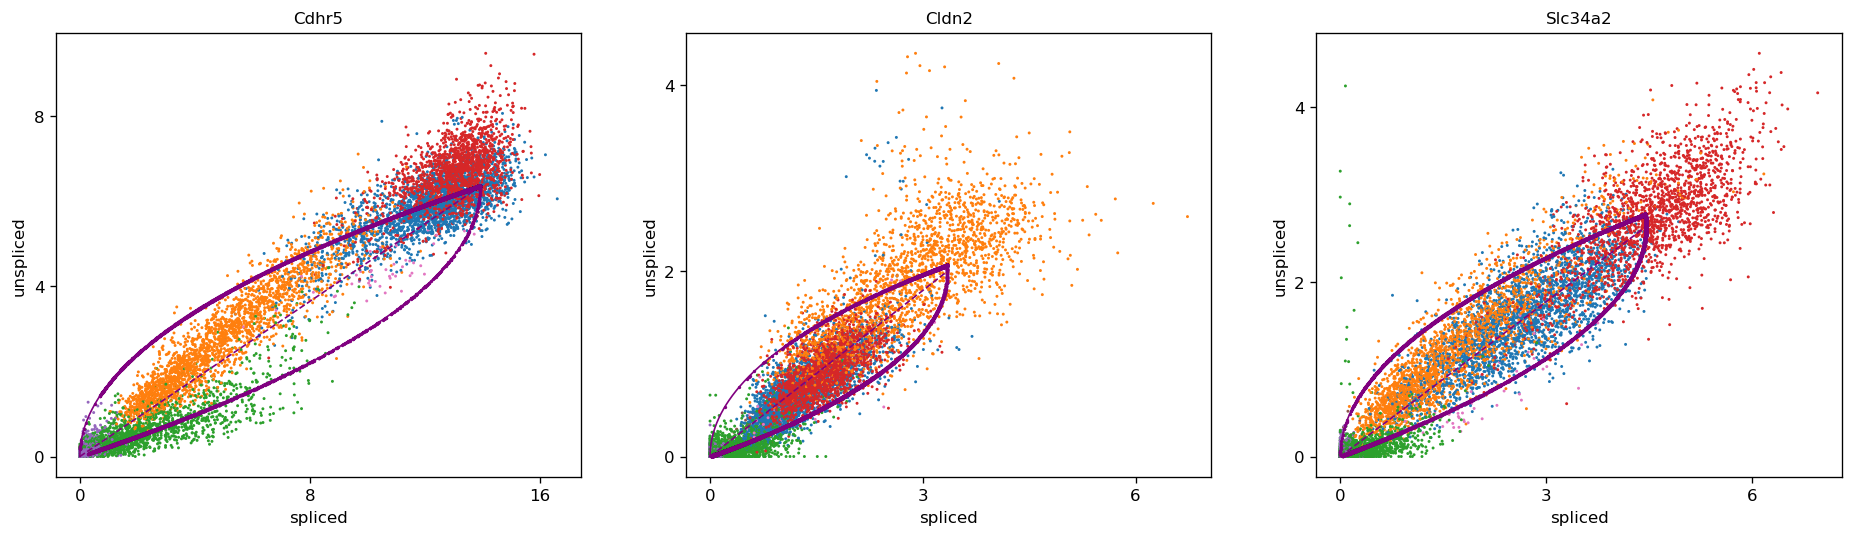

In [57]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.scatter(adata, df['1'][:3],color="leiden",dpi=120)

# Velocities in cycling progenitors

- cell cycle genes information is required.


In [68]:
adata.var.index

Index(['0610005C13Rik', '1110017D15Rik', '2610528A11Rik', '5330417C22Rik',
       '6330403K07Rik', 'A330076H08Rik', 'AU021092', 'Aadat', 'Abca13',
       'Abcb11',
       ...
       'Uox', 'Upk1a', 'Upk1b', 'Upk3a', 'Upk3b', 'Vsnl1', 'Vsx2', 'Vwf',
       'Wif1', 'Wnt3'],
      dtype='object', name='gene_name', length=374)

In [ ]:
scv.tl.score_genes_cell_cycle(adata, )
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])


# Speed and Coherence

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


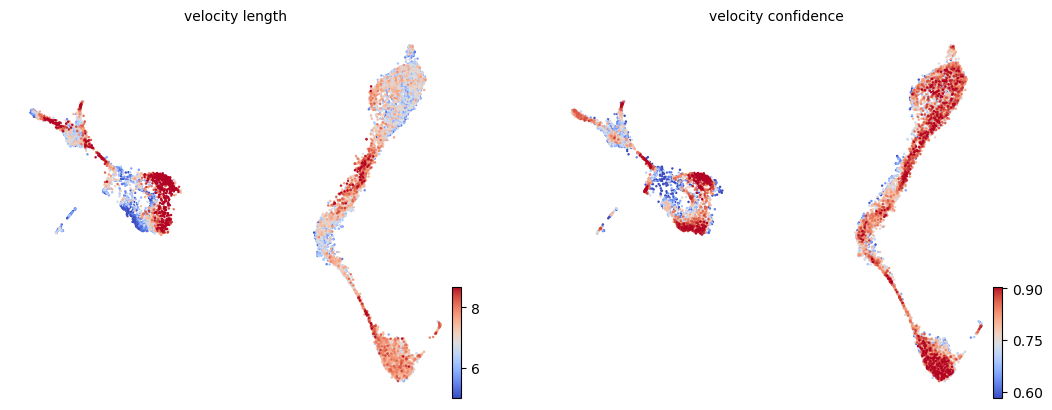

In [70]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

In [73]:
adata.obs

,cell_id,x_centroid,y_centroid,transcript_counts,total_counts,cell_area,nucleus_area,n_counts,leiden,velocity_self_transition,root_cells,end_points,velocity_pseudotime,latent_time,velocity_length,velocity_confidence,velocity_confidence_transition
20498,adigbgem-1,4820.892090,5062.135254,136,136,328.195637,30.796564,36.464664,5,0.260612,0.020711,0.000131,0.614082,1.000000,4.12,0.763682,0.500713
20499,adigbhac-1,4819.842773,5077.682129,151,151,373.532514,18.785001,57.067398,5,0.506395,0.955727,0.000084,0.716006,0.618653,5.24,0.583596,0.216040
20500,adigcpok-1,4832.402344,5084.256348,201,201,246.553134,34.409064,30.941586,5,0.336485,0.090970,0.000229,0.618776,0.846638,6.43,0.840063,0.448739
20501,adigdlmn-1,4839.102539,5062.535645,56,56,101.285472,19.733282,28.740786,5,0.451472,0.012557,0.000149,0.615762,0.928927,5.27,0.799541,0.191898
20502,adigedni-1,4840.291992,5072.097168,41,41,106.162348,30.570782,28.104876,5,0.403540,0.104515,0.000262,0.614194,0.909867,4.51,0.660117,0.336468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195222,mnenccah-1,6074.336426,5090.879883,130,130,64.483127,5.644531,52.909500,3,0.459735,0.018450,0.395645,0.085744,0.358989,7.46,0.720695,0.203207
1195224,mnendgei-1,6086.555664,5090.505859,381,381,171.458287,22.532970,53.429916,3,0.457270,0.014364,0.622966,0.079364,0.375183,6.68,0.710990,0.178051
1195225,mnendlll-1,6097.374023,5089.086914,339,339,202.751570,30.886876,51.443302,3,0.347863,0.044079,0.297984,0.080506,0.417236,7.06,0.877250,0.369739
1195286,mnepghpk-1,6206.877441,5096.514160,171,171,96.544066,41.679220,60.835613,4,0.138243,0.027283,0.296240,0.735739,0.473670,6.87,0.536610,0.622865


In [81]:
adata.obs[["root_cells","end_points"]]

,root_cells,end_points
20498,0.020711,0.000131
20499,0.955727,0.000084
20500,0.090970,0.000229
20501,0.012557,0.000149
20502,0.104515,0.000262
...,...,...
1195222,0.018450,0.395645
1195224,0.014364,0.622966
1195225,0.044079,0.297984
1195286,0.027283,0.296240


In [83]:
adata.obs.groupby('leiden')[["velocity_length","velocity_confidence"]].mean().T

,velocity_length,velocity_confidence
leiden,,
0,6.375082,0.769801
1,6.829580,0.767297
2,6.935723,0.765330
3,7.029079,0.775633
4,6.563184,0.706008
5,5.325081,0.718843
6,7.498163,0.754311


In [84]:

df = adata.obs.groupby('leiden')[["velocity_length","velocity_confidence"]].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

leiden,0,1,2,3,4,5,6
velocity_length,6.375082,6.829580,6.935723,7.029079,6.563184,5.325081,7.498163
velocity_confidence,0.769801,0.767297,0.765330,0.775633,0.706008,0.718843,0.754311


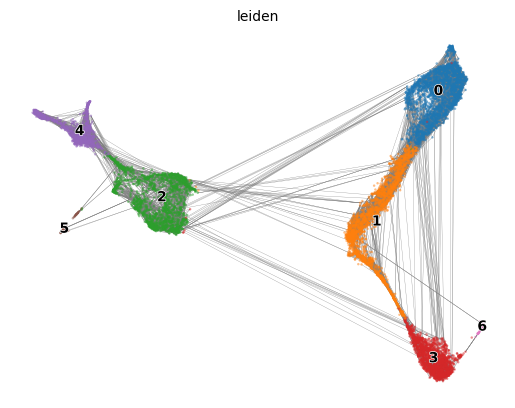

In [93]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.velocity_graph(adata, threshold=.3,color="leiden",alpha=0.5,)

In [108]:
adata.obs.iloc[110]

cell_id                            adjbkfoj-1
x_centroid                        4942.480957
y_centroid                        4517.591309
transcript_counts                         288
total_counts                              288
cell_area                          136.913755
nucleus_area                        27.906564
n_counts                            50.024197
leiden                                      1
velocity_self_transition              0.44763
root_cells                           0.025164
end_points                           0.000382
velocity_pseudotime                  0.033886
latent_time                          0.334477
velocity_length                          5.95
velocity_confidence                  0.917806
velocity_confidence_transition        0.23903
Name: 20759, dtype: object

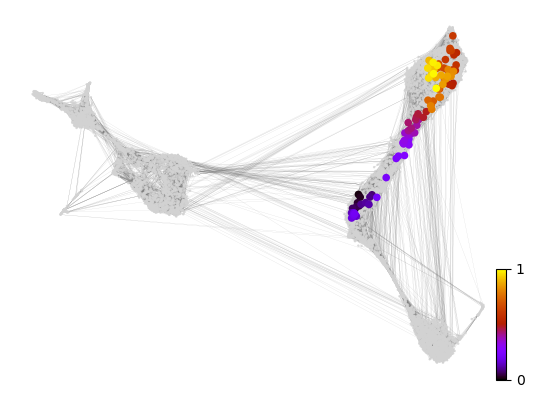

In [107]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=110)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

### Velocity Pseudotime

/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:6

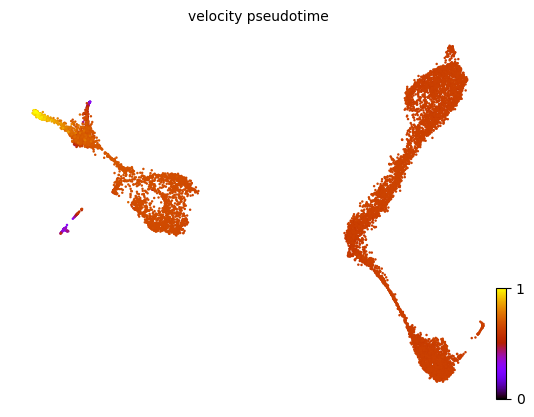

In [110]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

### PAGA velocity graph 

In [118]:
adata.uns["neighbors"]

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'n_neighbors': 15,
  'method': 'umap',
  'random_state': 0,
  'metric': 'euclidean',
  'n_pcs': 0},
 'distances': <9569x9569 sparse matrix of type '<class 'numpy.float32'>'
 	with 153104 stored elements in Compressed Sparse Row format>,
 'connectivities': <9569x9569 sparse matrix of type '<class 'numpy.float32'>'
 	with 249630 stored elements in Compressed Sparse Row format>}

In [121]:
adata

AnnData object with n_obs × n_vars = 9569 × 374
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'leiden', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition'
    var: 'Ensemble ID', 'feature_types', 'genome', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'spearmans_score', 'velocity_score'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors', 'rank_velocity_genes', 'paga', 'leiden_sizes'
    obsm: 'spatial', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'spliced', '

In [ ]:
#adata.uns['neighbors']['distances'] = adata.obsp['distances']
#adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='leiden')
df = scv.get_df(adata, 'paga', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

- scv.tl.paga() has a bug: https://github.com/theislab/scvelo/issues/1241

## Stochastic Velocity 

In [74]:
adata = scv.read("data/Xenium_V1_mouse_pup_outs/adata_filtered.h5ad")

In [75]:
# filter, normalize 
sc.pp.filter_cells(adata,min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# pca, neighbours, umap, leiden
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=30,n_pcs=30)
sc.tl.umap(adata,min_dist=0.05)
sc.tl.leiden(adata)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [76]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
scv.tl.velocity(adata, mode='stochastic')

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [77]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:59) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:6

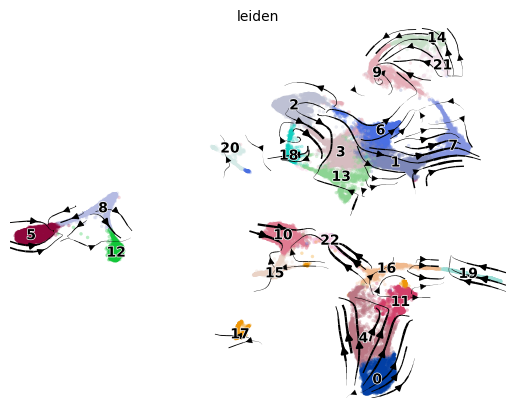

In [80]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color="leiden")